# Lab. 8: Multi-Objective Optimization

## Introduction

#### <u>The goal of this lab is to study different Multi-Objective Optimization approaches.</u>

For this problem, we will use two problems as benchmarks:
1. Kursawe's function:
$\underset{x}{min}\begin{cases}f_1(x) &= \sum_{i=1}^{n-1} \left[-10e^{-0.2\sqrt{x_i^2 + x_{i+1}^2}}\right] \\ f_2(x) &= \sum_{i=1}^n \left[|x_i|^{0.8} + 5\sin(x_i)^3\right] \\\end{cases}$ s.t. $x_i \in [-5, 5]; i \in [1,n]$
2. Multiple-disk clutch brake optimization: This real world optimization problem consists in the optimization of 5 paramters concernining multiple-disk clutch brakes. The parameters are shown visually in the image below.


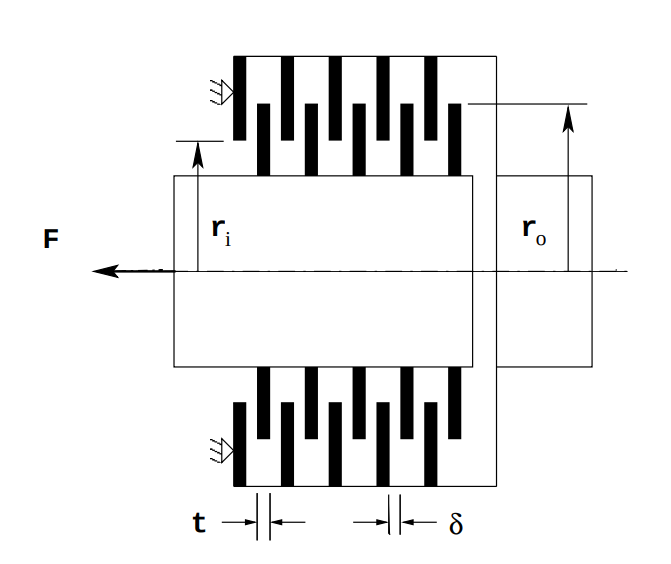

(Image taken from Deb and Srinivasan, "Innovization: Innovative Design Principles Through Optimization")

Two conflicting objectives are considered in the problem of this exercise:
1. minimization of break system mass(in kg)
2. minimization of stopping time(in s).

This problem is characterzied by five decision variables that are:
1. $r_i$ the inner radius in mm. $r_i = (60, 61, 62, . . . , 78, 79, 80)mm$
2. $r_o$ the outer radius in . $r_o = (90, 91, 92, . . . , 108, 109, 110)mm$
3. $t$ the tickness of discs in mm. $t = (1, 1.5, 2, 2.5, 3)mm$
4. $F$ the actuating force in N(Newton). $F = (600, 610, 620, . . . , 980, 990, 1000)N$
5. $Z$ the number of discs. $Z = (2, 3, 4, 5, 6, 7, 8, 10)$

**For each of the exercises, perform multiple runs (with different random seeds) to reduce the effect of randomness on the results.**

### Helper functions

In [ ]:
import functools
from copy import copy
from dataclasses import dataclass
from typing import Any, Optional

import inspyred.ec.emo as emo
import matplotlib.pyplot as plt
import pylab as pl
from inspyred.benchmarks import Benchmark, Kursawe
from inspyred.ec import (
    EvolutionaryComputation,
    Individual,
    replacers,
    selectors,
    terminators,
    variators,
)
from inspyred.ec.variators import mutator
from numpy.random import RandomState
from numpy.typing import NDArray

In [ ]:
# @markdown Implementation of benchmarks and utilites (double click to open)
class NumpyRandomWrapper(RandomState):
    def __init__(self, seed: Optional[int] = None) -> None:
        super(NumpyRandomWrapper, self).__init__(seed)

    def sample(
        self, pop: int | list[float] | NDArray[pl.float64], k: int
    ) -> NDArray[pl.float64]:
        population: list[int | float] | NDArray[pl.float64]
        if isinstance(pop, int):
            population = list(range(pop))
        else:
            population = pop

        return pl.asarray(
            [
                population[i]
                for i in self._choice_without_replacement(len(population), k)
            ]
        )

    def random(self) -> float:  # type: ignore
        return self.random_sample()

    def gauss(self, mu: float, sigma: float) -> float:
        return self.normal(mu, sigma)

    def _choice_without_replacement(self, n: int, size: int) -> set[int]:
        result: set[int] = set()
        while len(result) < size:
            result.add(self.randint(0, n))
        return result


def initial_pop_observer(
    population: list[Individual],
    num_generations: int,
    num_evaluations: int,
    args: dict[str, Any],
) -> None:
    if num_generations == 0:
        args["initial_pop_storage"]["individuals"] = pl.asarray(
            [guy.candidate for guy in population]
        )
        args["initial_pop_storage"]["fitnesses"] = pl.asarray(
            [guy.fitness for guy in population]
        )


def generator(random: NumpyRandomWrapper, args: Any) -> NDArray[pl.float64]:
    return pl.asarray(
        [
            random.uniform(args["pop_init_range"][0], args["pop_init_range"][1])
            for _ in range(args["num_vars"])
        ]
    )


def generator_wrapper(func: Any) -> Any:
    @functools.wraps(func)
    def _generator(random: NumpyRandomWrapper, args: Any) -> NDArray[pl.float64]:
        return pl.asarray(func(random, args))

    return _generator


class CombinedObjectives(emo.Pareto):
    def __init__(self, pareto: emo.Pareto, args: dict[str, Any]) -> None:
        """edit this function to change the way that multiple objectives
        are combined into a single objective

        """
        emo.Pareto.__init__(self, pareto.values)
        weights: NDArray[pl.float64]
        if "fitness_weights" in args:
            weights = pl.asarray(args["fitness_weights"])
        else:
            weights = pl.asarray([1.0 for _ in pareto.values])

        self.fitness = sum(pl.asarray(pareto.values) * weights)

    def __lt__(self, other: Any) -> bool:
        if not isinstance(other, CombinedObjectives):
            raise ValueError("Cannot compare CombinedObjectives with other types")
        return self.fitness < other.fitness


def single_objective_evaluator(
    candidates: list[Individual], args: dict[str, Any]
) -> list[CombinedObjectives]:
    problem: Benchmark = args["problem"]
    return [
        CombinedObjectives(fit, args) for fit in problem.evaluator(candidates, args)
    ]


# parameters, see Deb 2006
Delta_R = 20  # mm
L_max = 30  # mm
delta = 0.5  # mm
p_max = 1  # MPa
V_sr_max = 10  # m/s
n = 250  # rpm
mu = 0.5
s = 1.5
M_s = 40  # Nm
omega = pl.pi * n / 30.0  # rad/s
rho = 0.0000078  # kg/mm^3
T_max = 15  # s
M_f = 3  # Nm
I_z = 55  # kg*m^2


@dataclass
class CandidateDiskClutchBrake:
    inner_radius: int
    outer_radius: int
    thickness: float
    force: int
    number_of_disks: int

    def __iter__(self):
        return iter(
            [
                self.inner_radius,
                self.outer_radius,
                self.thickness,
                self.force,
                self.number_of_disks,
            ]
        )

    def __getitem__(self, index: int):
        return [
            self.inner_radius,
            self.outer_radius,
            self.thickness,
            self.force,
            self.number_of_disks,
        ][index]

    def __setitem__(self, index: int, value: float):
        if index == 0:
            self.inner_radius = int(value)
        elif index == 1:
            self.outer_radius = int(value)
        elif index == 2:
            self.thickness = value
        elif index == 3:
            self.force = int(value)
        elif index == 4:
            self.number_of_disks = int(value)
        else:
            raise IndexError("Index out of range")

    def __len__(self):
        return 5

    @property
    def bounds(self):
        return [
            pl.arange(60, 81, 1),
            pl.arange(90, 111, 1),
            pl.arange(1.5, 3.5, 0.5),
            pl.arange(600, 1010, 10),
            pl.arange(2, 10, 1),
        ]


# possible values
VALUES: list[NDArray[pl.float64]] = [
    pl.arange(60, 81, 1.0),
    pl.arange(90, 111, 1.0),
    pl.arange(1.5, 3.5, 0.5),
    pl.arange(600, 1010, 10.0),
    pl.arange(2, 10, 1.0),
]


class DiskClutchBounder(object):
    def __call__(
        self, candidate: NDArray[pl.float64], args: dict[str, Any]
    ) -> NDArray[pl.float64]:
        for i, c in enumerate(candidate):
            candidate[i] = self._closest(c, i)
        return candidate

    def _closest(self, target: float, index: int) -> float:
        return min(VALUES[index], key=lambda x: abs(x - target))


class ConstrainedPareto(emo.Pareto):
    def __init__(
        self,
        values: Optional[list[float]] = None,
        violations: Optional[int] = None,
        ec_maximize: bool = True,
    ):
        emo.Pareto.__init__(self, values)
        self.violations = violations
        self.ec_maximize = ec_maximize

    def __lt__(self, other: Any) -> bool:
        if not isinstance(other, ConstrainedPareto):
            raise ValueError("Cannot compare CombinedObjectives with other types")

        if self.violations is None:
            return emo.Pareto.__lt__(self, other)
        elif len(self.values) != len(other.values):
            raise ValueError("Cannot compare Pareto fronts with different lengths")
        else:
            if other.violations is not None and self.violations > other.violations:
                # if self has more violations than other
                # return true if EC is maximizing otherwise false
                return self.ec_maximize
            elif other.violations is not None and other.violations > self.violations:
                # if other has more violations than self
                # return true if EC is minimizing otherwise false
                return not self.ec_maximize
            elif self.violations > 0:
                # if both equally infeasible (> 0) than cannot compare
                return False
            else:
                # only consider regular dominance if both are feasible
                not_worse = True
                strictly_better = False
                if isinstance(self.maximize, list):
                    for x, y, m in zip(self.values, other.values, self.maximize):
                        if m:
                            if x > y:
                                not_worse = False
                            elif y > x:
                                strictly_better = True
                        else:
                            if x < y:
                                not_worse = False
                            elif y < x:
                                strictly_better = True
                else:
                    raise ValueError("maximize must be a list")
            return not_worse and strictly_better


class DiskClutchBrake(Benchmark):
    def __init__(self, constrained: bool = False) -> None:
        Benchmark.__init__(self, 5, 2)
        self.bounder = DiskClutchBounder()
        self.maximize = False
        self.constrained = constrained

    def generator(
        self, random: NumpyRandomWrapper, args: dict[str, Any]
    ) -> list[NDArray[pl.float64]]:
        return [random.sample(VALUES[i], 1)[0] for i in range(self.dimensions)]

    def evaluator(self, candidates: list[NDArray[pl.float64]], args: dict[str, Any]):
        fitness: list[ConstrainedPareto] = []
        for c in candidates:
            f1 = pl.pi * (c[1] ** 2 - c[0] ** 2) * c[2] * (c[4] + 1) * rho

            M_h = (
                (2.0 / 3.0)
                * mu
                * c[3]
                * c[4]
                * (c[1] ** 3 - c[0] ** 3)
                / (c[1] ** 2 - c[0] ** 2)
            ) / 1000.0  # N*m
            T = (I_z * omega) / (M_h + M_f)

            f2 = T

            fitness.append(
                ConstrainedPareto([f1, f2], self.constraint_function(c), self.maximize)
            )

        return fitness

    def constraint_function(self, candidate: NDArray[pl.float64]) -> int:
        if not self.constrained:
            return 0
        """Return the magnitude of constraint violations."""
        A = pl.pi * (candidate[1] ** 2 - candidate[0] ** 2)  # mm^2
        p_rz = candidate[3] / A  # N/mm^2
        R_sr = (
            (2.0 / 3.0)
            * (candidate[1] ** 3 - candidate[0] ** 3)
            / (candidate[1] ** 2 - candidate[0] ** 2)
        )  # mm
        V_sr = pl.pi * R_sr * n / 30000.0  # m/s

        M_h = (
            (2.0 / 3.0)
            * mu
            * candidate[3]
            * candidate[4]
            * (candidate[1] ** 3 - candidate[0] ** 3)
            / (candidate[1] ** 2 - candidate[0] ** 2)
        ) / 1000.0  # N*m

        T = (I_z * omega) / (M_h + M_f)

        violations: int = 0
        # g_1
        if (candidate[1] - candidate[0] - Delta_R) < 0:
            violations -= candidate[1] - candidate[0] - Delta_R
        # g_2
        if (L_max - (candidate[4] + 1) * (candidate[2] + delta)) < 0:
            violations -= L_max - (candidate[4] + 1) * (candidate[2] + delta)
        # g_3
        if (p_max - p_rz) < 0:
            violations -= p_max - p_rz
        # g_4
        if (p_max * V_sr_max - p_rz * V_sr) < 0:
            violations -= p_max * V_sr_max - p_rz * V_sr
        # g_5
        if (V_sr_max - V_sr) < 0:
            violations -= V_sr_max - V_sr
        # g_6
        if (M_h - s * M_s) < 0:
            violations -= M_h - s * M_s
        # g_7
        if T < 0:
            violations -= T
        # g_8
        if (T_max - T) < 0:
            violations -= T_max - T

        return violations


@mutator
def disk_clutch_brake_mutation(
    random: NumpyRandomWrapper, candidate: NDArray[pl.float64], args: dict[str, Any]
) -> NDArray[pl.float64]:
    mut_rate = args.setdefault("mutation_rate", 0.1)
    bounder: DiskClutchBounder = args["_ec"].bounder
    mutant = copy(candidate)
    for i, _ in enumerate(mutant):
        if random.random() < mut_rate:
            mutant[i] += random.gauss(0, (VALUES[i][-1] - VALUES[i][0]) / 10.0)
    mutant = bounder(mutant, args)
    return mutant


class NSGA2(emo.NSGA2):
    def __init__(self, random: NumpyRandomWrapper) -> None:
        emo.NSGA2.__init__(self, random)
        self.population_archive: list[list[Individual]] = []

    # helper function used to store the various populations at each generation
    def _best_archiver(
        self,
        random: NumpyRandomWrapper,
        population: list[Individual],
        archive: list[Individual],
        args: dict[str, Any],
    ) -> list[Individual]:
        self.population_archive.append(population)
        new_archive = archive
        for ind in population:
            if len(new_archive) == 0:
                new_archive.append(ind)
            else:
                should_remove = []
                should_add = True
                for a in new_archive:
                    if (pl.array(ind.candidate) == pl.array(a.candidate)).all():
                        should_add = False
                        break
                    elif ind < a:
                        should_add = False
                    elif ind > a:
                        should_remove.append(a)
                for r in should_remove:
                    new_archive.remove(r)
                if should_add:
                    new_archive.append(ind)
        return new_archive

    def run_nsga2(
        self,
        problem: Benchmark,
        display: bool = False,
        num_vars: int = 0,
        use_bounder: bool = True,
        variator: Optional[Any] = None,
        **kwargs: Any,
    ) -> tuple[NDArray[pl.float64], NDArray[pl.float64], list[NDArray[pl.float64]]]:
        """run NSGA2 on the given problem"""

        # create dictionaries to store data about initial population, and lines
        initial_pop_storage: dict[str, Any] = {}

        self.archiver = self._best_archiver
        self.terminator = terminators.generation_termination
        if variator is None:
            self.variator = [variators.blend_crossover, variators.gaussian_mutation]
        else:
            self.variator = variator

        kwargs["num_selected"] = kwargs["pop_size"]
        if use_bounder:
            kwargs["bounder"] = problem.bounder

        if "pop_init_range" in kwargs:
            kwargs["generator"] = generator
        else:
            kwargs["generator"] = problem.generator
        final_pop: list[Individual] = self.evolve(
            evaluator=problem.evaluator,
            maximize=problem.maximize,
            initial_pop_storage=initial_pop_storage,
            num_vars=num_vars,
            **kwargs,
        )
        # assert isinstance(final_pop, list)
        all_populations = self.population_archive
        all_populations_fitnesses: list[NDArray[pl.float64]] = [
            pl.asarray([guy.fitness for guy in pop]) for pop in all_populations
        ]

        # best_guy = final_pop[0].candidate[0:num_vars] # type: ignore
        # best_fitness: float = final_pop[0].fitness
        final_pop_fitnesses: NDArray[pl.float64] = pl.asarray(
            [guy.fitness for guy in final_pop]
        )
        final_pop_candidates: NDArray[pl.float64] = pl.asarray([guy.candidate[0:num_vars] for guy in final_pop])  # type: ignore

        return final_pop_candidates, final_pop_fitnesses, all_populations_fitnesses


def run_ga(
    random: NumpyRandomWrapper,
    problem: Benchmark,
    display: bool = False,
    num_vars: int = 0,
    maximize: bool = False,
    use_bounder: bool = True,
    **kwargs: Any,
) -> tuple[NDArray[pl.float64], float]:
    """run a GA on the given problem"""

    # create dictionaries to store data about initial population, and lines
    initial_pop_storage: dict[str, Any] = {}

    algorithm = EvolutionaryComputation(random)
    algorithm.terminator = terminators.generation_termination
    algorithm.replacer = replacers.generational_replacement
    algorithm.variator = [variators.uniform_crossover, variators.gaussian_mutation]  # type: ignore
    algorithm.selector = selectors.tournament_selection
    algorithm.observer = initial_pop_observer

    kwargs["num_selected"] = kwargs["pop_size"]
    if use_bounder:
        kwargs["bounder"] = problem.bounder
    if "pop_init_range" in kwargs:
        kwargs["generator"] = generator
    else:
        kwargs["generator"] = problem.generator

    kwargs["problem"] = problem
    final_pop: list[Individual] = algorithm.evolve(
        evaluator=single_objective_evaluator,
        maximize=problem.maximize,
        initial_pop_storage=initial_pop_storage,
        num_vars=num_vars,
        **kwargs,
    )

    best_guy: NDArray[pl.float64] = final_pop[0].candidate  # type: ignore
    best_fitness: float = final_pop[0].fitness  # type: ignore
    final_pop_fitnesses: NDArray[pl.float64] = pl.asarray(
        [guy.fitness for guy in final_pop]
    )
    # final_pop_candidates: NDArray[pl.float64] = pl.asarray([guy.candidate for guy in final_pop])

    if display:
        # print("Candidates: ", final_pop_candidates.shape)
        # print("Fitnesses: ", final_pop_fitnesses.shape)
        _, ax = plt.subplots(1, 1)
        ax.plot(final_pop_fitnesses.T[0], final_pop_fitnesses.T[1], "ro")
        ax.set_xlabel("f1")
        ax.set_ylabel("f2")
        ax.set_title("Final population")
        # plot candidates as heatmap
        # ax[1].hist2d(final_pop_candidates.T[0], final_pop_candidates.T[1], bins=50)

        plt.show()

    return best_guy, best_fitness


def plot_pareto(
    final_pop_fitnesses: NDArray[pl.float64],
    function_labels: Optional[tuple[str, str]] = None,
) -> None:
    plt.scatter(
        final_pop_fitnesses.T[0],
        final_pop_fitnesses.T[1],
        color="red",
        label="Pareto front",
    )

    if not function_labels:
        plt.xlabel("f1")
        plt.ylabel("f2")
    else:
        plt.xlabel(function_labels[0])
        plt.ylabel(function_labels[1])

    plt.legend(loc="upper right")
    plt.legend()
    plt.show()


def plot_pareto_rank(
    all_populations: list[NDArray[pl.float64]],
    function_labels: Optional[tuple[str, str]] = None,
) -> None:
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(10)
    fig.set_figheight(7)

    pareto_front = all_populations[-1]
    ax.scatter(pareto_front.T[0], pareto_front.T[1], color="red", label="Pareto front")

    for i in range(min(len(all_populations), 5)):
        ax.scatter(
            all_populations[i].T[0],
            all_populations[i].T[1],
            label=("Front " + str(i + 1)),
        )

    if not function_labels:
        ax.set_xlabel("f1")
        ax.set_ylabel("f2")
    else:
        ax.set_xlabel(function_labels[0])
        ax.set_ylabel(function_labels[1])
    plt.legend(loc="upper right")
    plt.legend()
    plt.show()


def compute_pareto_front_statistics(
    final_pop_candidates: NDArray[pl.float64],
    final_pop_fitnesses: NDArray[pl.float64],
    num_objectives: int,
) -> list[tuple[NDArray[pl.float64], NDArray[pl.float64]]]:
    results: list[tuple[NDArray[pl.float64], NDArray[pl.float64]]] = []
    for i in range(num_objectives):
        # candidates that minimize f_i
        f_min_index = final_pop_fitnesses.T[i].argmin()
        f_min_candidate = final_pop_candidates[f_min_index]
        f_min_fitness = final_pop_fitnesses[f_min_index]
        results.append((f_min_candidate, f_min_fitness))

    # fitness closest to the origin
    origin_distance = pl.sqrt(pl.sum(final_pop_fitnesses**2, axis=1))
    closest_index = origin_distance.argmin()
    closest_candidate = final_pop_candidates[closest_index]
    closest_fitness = final_pop_fitnesses[closest_index]
    results.append((closest_candidate, closest_fitness))

    return results

### Exercises

#### Exercise 1/2: Kursawe's function

1. Weighted sum of the objectives: what's the influence of the weights on the output of the search process?
2. Using NSGA-II, plot the Pareto front of the solutions obtained during the optimization process.
3. Compare the weighted-sum method with NSGA-II

In [ ]:
# Run the GA on the Kursawe problem with different fitness weights
problem = Kursawe(3)

# Parameters for the GA
args: dict[str, Any] = {}
fitness_weights = [[1, 0], [0, 1], [0.5, 0.5], [0.3, 0.7], [0.7, 0.3]]
args["pop_size"] = 50
args["max_generations"] = 100
args["fitness_weights"] = [1, 1]

num_simulations = 50
best_seed: Optional[int]
overall_best: Optional[float]
best_fitnesses: list[float]


for weights in fitness_weights:
    args["fitness_weights"] = weights
    best_seed = None
    overall_best = None
    best_fitnesses = []
    for sim in range(num_simulations):
        seed = sim * 17 + 51
        # Initialize a random number generator with a seed
        rng = NumpyRandomWrapper(sim * 17 + 51)
        # Run the GA
        best_guy, best_fitness = run_ga(rng, problem, num_vars=3, display=False, **args)
        best_fitnesses.append(best_fitness)
        if best_seed is None or overall_best is None or best_fitness < overall_best:
            best_seed = seed
            overall_best = best_fitness

    rng = NumpyRandomWrapper(best_seed)
    # Run the GA
    best_guy, best_fitness = run_ga(
        rng, problem, num_vars=3, display=True, maximize=False, **args
    )
    print("Fitness weights: ", weights)
    print("Best solution: ", best_guy)
    print("Best fitness: ", best_fitness)
    # Print the mean and standard deviation of the best fitness
    print("Mean fitness: ", pl.mean(best_fitnesses, axis=0))
    print("Standard deviation of fitness: ", pl.std(best_fitnesses, axis=0))

In [ ]:
# Run NSGA2 on the Kursawe problem
problem = Kursawe(3)

num_simulations = 50
best_seed: Optional[int] = None
overall_best: Optional[float] = None
best_f1_fitness: list[float] = []
best_f2_fitness: list[float] = []
best_origin_fitness: list[float] = []

for sim in range(num_simulations):
    seed = sim * 17 + 51
    # Initialize a random number generator with a seed
    rng = NumpyRandomWrapper(seed)
    nsga2 = NSGA2(rng)
    # Run the NSGA2
    (
        final_pop_candidates,
        final_pop_fitnesses,
        all_populations_fitnesses,
    ) = nsga2.run_nsga2(problem, num_vars=3, **args)
    # Compute the statistics of the Pareto front
    results = compute_pareto_front_statistics(
        final_pop_candidates, final_pop_fitnesses, 2
    )
    best_f1_fitness.append(results[0][1].item())
    best_f2_fitness.append(results[1][1].item())
    best_origin_fitness.append(results[2][1].item())

    if best_seed is None or overall_best is None or results[2][1][0] < overall_best:
        best_seed = seed
        overall_best = results[2][1][0]

    # Print the results
    # print(f"Best solution for objective f1 for iteration {sim}: ", results[0][0])
    # print(f"Best fitness for objective f1 for iteration {sim}: ", results[0][1])
    # print(f"Best solution for objective f2 for iteration {sim}: ", results[1][0])
    # print(f"Best fitness for objective f2 for iteration {sim}: ", results[1][1])
    # print(f"Best solution closest to the origin for iteration {sim}: ", results[2][0])
    # print(f"Best fitness closest to the origin for iteration {sim}: ", results[2][1])

# Print the mean and standard deviation of the best fitness
print("Mean fitness for f1: ", pl.mean(best_f1_fitness, axis=0))
print("Standard deviation of fitness for f1: ", pl.std(best_f1_fitness, axis=0))
print("Mean fitness for f2: ", pl.mean(best_f2_fitness, axis=0))
print("Standard deviation of fitness for f2: ", pl.std(best_f2_fitness, axis=0))
print("Mean fitness closest ti origin: ", pl.mean(best_origin_fitness, axis=0))
print("Standard deviation closest to fitness: ", pl.std(best_origin_fitness, axis=0))

nsga2 = NSGA2(NumpyRandomWrapper(best_seed))
final_pop_candidates, final_pop_fitnesses, all_populations_fitnesses = nsga2.run_nsga2(
    problem, num_vars=3, **args
)
# print("Best solutions: ", final_pop_candidates)
# print("Best fitnesses: ", final_pop_fitnesses)

plot_pareto(final_pop_fitnesses, ("f1", "f2"))
plot_pareto_rank(all_populations_fitnesses, ("f1", "f2"))
results = compute_pareto_front_statistics(final_pop_candidates, final_pop_fitnesses, 2)
print(
    f"Best solution for objective f1 with {num_simulations} simulations: ",
    results[0][0],
)
print(
    f"Best fitness for objective f1 with {num_simulations} simulations: ", results[0][1]
)
print(
    f"Best solution for objective f2 with {num_simulations} simulations: ",
    results[1][0],
)
print(
    f"Best fitness for objective f2 with {num_simulations} simulations: ", results[1][1]
)
print(
    f"Best solution closest to the origin with {num_simulations} simulations: ",
    results[2][0],
)
print(
    f"Best fitness closest to the origin with {num_simulations} simulations: ",
    results[2][1],
)

#### Exercise 2/2: Multi-disk clutch brake optimization

1. Weighted sum of the objectives: what's the influence of the weights on the output of the search process?
2. Using NSGA-II, plot the Pareto front of the solutions obtained during the optimization process.
3. Compare the weighted-sum method with NSGA-II

In [ ]:
# Run the GA on the disk clutch brake problem
problem = DiskClutchBrake(False)

# Parameters for the GA
args: dict[str, Any] = {}
fitness_weights = [[1, 0], [0, 1], [1, 1], [1, 2], [2, 1]]
args["pop_size"] = 50
args["max_generations"] = 50
args["variator"] = [variators.blend_crossover, disk_clutch_brake_mutation]

num_simulations = 50
best_seed: Optional[int] = None
overall_best: Optional[float] = None
best_fitnesses: list[float] = []


for weights in fitness_weights:
    args["fitness_weights"] = weights
    best_seed = None
    overall_best = None
    best_fitnesses = []
    for sim in range(num_simulations):
        seed = sim * 17 + 51
        # Initialize a random number generator with a seed
        rng = NumpyRandomWrapper(sim * 17 + 51)
        # Run the GA
        best_guy, best_fitness = run_ga(rng, problem, num_vars=3, display=False, **args)
        best_fitnesses.append(best_fitness)
        if best_seed is None or overall_best is None or best_fitness < overall_best:
            best_seed = seed
            overall_best = best_fitness

    rng = NumpyRandomWrapper(best_seed)
    # Run the GA
    best_guy, best_fitness = run_ga(
        rng, problem, num_vars=3, display=True, maximize=False, **args
    )
    print("Fitness weights: ", weights)
    print("Best solution: ", best_guy)
    print("Best fitness: ", best_fitness)
    # Print the mean and standard deviation of the best fitness
    print("Mean fitness: ", pl.mean(best_fitnesses, axis=0))
    print("Standard deviation of fitness: ", pl.std(best_fitnesses, axis=0))

In [ ]:
# parameters for NSGA-2
args: dict[str, Any] = {}
args["pop_size"] = 50
args["max_generations"] = 50
args["variator"] = [variators.blend_crossover, disk_clutch_brake_mutation]
problem = DiskClutchBrake(False)

num_simulations = 50
best_seed: Optional[int] = None
overall_best: Optional[float] = None
best_f1_fitness: list[float] = []
best_f2_fitness: list[float] = []
best_origin_fitness: list[float] = []

for sim in range(num_simulations):
    seed = sim * 17 + 51
    # Initialize a random number generator with a seed
    rng = NumpyRandomWrapper(seed)
    nsga2 = NSGA2(rng)
    # Run the NSGA2
    (
        final_pop_candidates,
        final_pop_fitnesses,
        all_populations_fitnesses,
    ) = nsga2.run_nsga2(problem, num_vars=3, **args)
    # Compute the statistics of the Pareto front
    results = compute_pareto_front_statistics(
        final_pop_candidates, final_pop_fitnesses, 2
    )
    best_f1_fitness.append(results[0][1].item())
    best_f2_fitness.append(results[1][1].item())
    best_origin_fitness.append(results[2][1].item())

    if best_seed is None or overall_best is None or results[2][1][0] < overall_best:
        best_seed = seed
        overall_best = results[2][1][0]

    # Print the results
    # print(f"Best solution for objective f1 for iteration {sim}: ", results[0][0])
    # print(f"Best fitness for objective f1 for iteration {sim}: ", results[0][1])
    # print(f"Best solution for objective f2 for iteration {sim}: ", results[1][0])
    # print(f"Best fitness for objective f2 for iteration {sim}: ", results[1][1])
    # print(f"Best solution closest to the origin for iteration {sim}: ", results[2][0])
    # print(f"Best fitness closest to the origin for iteration {sim}: ", results[2][1])

# Print the mean and standard deviation of the best fitness
print("Mean fitness for f1: ", pl.mean(best_f1_fitness, axis=0))
print("Standard deviation of fitness for f1: ", pl.std(best_f1_fitness, axis=0))
print("Mean fitness for f2: ", pl.mean(best_f2_fitness, axis=0))
print("Standard deviation of fitness for f2: ", pl.std(best_f2_fitness, axis=0))
print("Mean fitness closest ti origin: ", pl.mean(best_origin_fitness, axis=0))
print("Standard deviation closest to fitness: ", pl.std(best_origin_fitness, axis=0))

nsga2 = NSGA2(NumpyRandomWrapper(best_seed))
final_pop_candidates, final_pop_fitnesses, all_populations_fitnesses = nsga2.run_nsga2(
    problem, num_vars=3, **args
)
# print("Best solutions: ", final_pop_candidates)
# print("Best fitnesses: ", final_pop_fitnesses)

plot_pareto(final_pop_fitnesses, ("f1", "f2"))
plot_pareto_rank(all_populations_fitnesses, ("f1", "f2"))
results = compute_pareto_front_statistics(final_pop_candidates, final_pop_fitnesses, 2)
print(f"Best solution for objective f1 for iteration {sim}: ", results[0][0])
print(f"Best fitness for objective f1 for iteration {sim}: ", results[0][1])
print(f"Best solution for objective f2 for iteration {sim}: ", results[1][0])
print(f"Best fitness for objective f2 for iteration {sim}: ", results[1][1])
print(f"Best solution closest to the origin for iteration {sim}: ", results[2][0])
print(f"Best fitness closest to the origin for iteration {sim}: ", results[2][1])

In [ ]:
# Run the GA on the Disk Clutch Brake problem with different fitness weights
problem = DiskClutchBrake(True)

# Parameters for the GA
args: dict[str, Any] = {}
fitness_weights = [[1, 0], [0, 1], [1, 1], [1, 2], [2, 1]]
args["pop_size"] = 50
args["max_generations"] = 50
args["variator"] = [variators.blend_crossover, disk_clutch_brake_mutation]

num_simulations = 50
best_seed: Optional[int]
overall_best: Optional[float]
best_fitnesses: list[float]


for weights in fitness_weights:
    args["fitness_weights"] = weights
    best_seed = None
    overall_best = None
    best_fitnesses = []
    for sim in range(num_simulations):
        seed = sim * 17 + 51
        # Initialize a random number generator with a seed
        rng = NumpyRandomWrapper(sim * 17 + 51)
        # Run the GA
        best_guy, best_fitness = run_ga(
            rng, problem, num_vars=3, display=False, maximize=False, **args
        )
        best_fitnesses.append(best_fitness)
        if best_seed is None or overall_best is None or best_fitness < overall_best:
            best_seed = seed
            overall_best = best_fitness

    rng = NumpyRandomWrapper(best_seed)
    # Run the GA
    best_guy, best_fitness = run_ga(
        rng, problem, num_vars=3, display=True, maximize=False, **args
    )
    print("Fitness weights: ", weights)
    print("Best solution: ", best_guy)
    print("Best fitness: ", best_fitness)
    # Print the mean and standard deviation of the best fitness
    print("Mean fitness: ", pl.mean(best_fitnesses, axis=0))
    print("Standard deviation of fitness: ", pl.std(best_fitnesses, axis=0))

In [ ]:
# constrained problem NSGA-2
args: dict[str, Any] = {}
args["pop_size"] = 50
args["max_generations"] = 50
args["variator"] = [variators.blend_crossover, disk_clutch_brake_mutation]
problem = DiskClutchBrake(True)

num_simulations = 50
best_seed: Optional[int] = None
overall_best: Optional[float] = None
best_f1_fitness: list[float] = []
best_f2_fitness: list[float] = []
best_origin_fitness: list[float] = []

for sim in range(num_simulations):
    seed = sim * 17 + 51
    # Initialize a random number generator with a seed
    rng = NumpyRandomWrapper(seed)
    nsga2 = NSGA2(rng)
    # Run the NSGA2
    (
        final_pop_candidates,
        final_pop_fitnesses,
        all_populations_fitnesses,
    ) = nsga2.run_nsga2(problem, num_vars=3, **args)
    # Compute the statistics of the Pareto front
    results = compute_pareto_front_statistics(
        final_pop_candidates, final_pop_fitnesses, 2
    )
    best_f1_fitness.append(results[0][1].item())
    best_f2_fitness.append(results[1][1].item())
    best_origin_fitness.append(results[2][1].item())

    if best_seed is None or overall_best is None or results[2][1][0] < overall_best:
        best_seed = seed
        overall_best = results[2][1][0]

    # Print the results
    # print(f"Best solution for objective f1 for iteration {sim}: ", results[0][0])
    # print(f"Best fitness for objective f1 for iteration {sim}: ", results[0][1])
    # print(f"Best solution for objective f2 for iteration {sim}: ", results[1][0])
    # print(f"Best fitness for objective f2 for iteration {sim}: ", results[1][1])
    # print(f"Best solution closest to the origin for iteration {sim}: ", results[2][0])
    # print(f"Best fitness closest to the origin for iteration {sim}: ", results[2][1])

# Print the mean and standard deviation of the best fitness
print("Mean fitness for f1: ", pl.mean(best_f1_fitness, axis=0))
print("Standard deviation of fitness for f1: ", pl.std(best_f1_fitness, axis=0))
print("Mean fitness for f2: ", pl.mean(best_f2_fitness, axis=0))
print("Standard deviation of fitness for f2: ", pl.std(best_f2_fitness, axis=0))
print("Mean fitness closest ti origin: ", pl.mean(best_origin_fitness, axis=0))
print("Standard deviation closest to fitness: ", pl.std(best_origin_fitness, axis=0))

nsga2 = NSGA2(NumpyRandomWrapper(best_seed))
final_pop_candidates, final_pop_fitnesses, all_populations_fitnesses = nsga2.run_nsga2(
    problem, num_vars=3, **args
)
# print("Best solutions: ", final_pop_candidates)
# print("Best fitnesses: ", final_pop_fitnesses)

plot_pareto(final_pop_fitnesses, ("f1", "f2"))
plot_pareto_rank(all_populations_fitnesses, ("f1", "f2"))
results = compute_pareto_front_statistics(final_pop_candidates, final_pop_fitnesses, 2)
print(f"Best solution for objective f1 for iteration {sim}: ", results[0][0])
print(f"Best fitness for objective f1 for iteration {sim}: ", results[0][1])
print(f"Best solution for objective f2 for iteration {sim}: ", results[1][0])
print(f"Best fitness for objective f2 for iteration {sim}: ", results[1][1])
print(f"Best solution closest to the origin for iteration {sim}: ", results[2][0])
print(f"Best fitness closest to the origin for iteration {sim}: ", results[2][1])